# Replication Baskaran & Hessami (2018)

**Disclaimer: This replication is work in progress, tentative and incomplete.**

This notebook contains a replication of Baskaran, T., & Hessami, Z. (2018) Does the Election of a Female Leader Clear the Way for More Women in Politics? *American Economic Journal: Economic Policy*, 10(3): 91-121.

For this purpose, first, data and method used as well as the key results are summarized briefly. Second, descriptive and graphical analyses are presented in preparation of third, a replication of the key results of the paper which is accompanied by critical review of the results presented.

## 1. Excecutive summary of the paper
* **Observation:** *Anti-female voter bias* results in **underrepresentation of females in politics**.


* **Research Hypothesis:** Exposure to a female mayor deminishes *anti-female biases* of voters.


* **Identification problems:**

    * Other potential drivers of this observation:
        - Political parties influence election outcomes. Thus, underrepresentation might be caused by *anti-female party biases*
        - Parties might anticipate *anti-female voter bias* and, therefore, are less willing to field female candidates in competitive races.
        - Women who expect discrimination might be reluctand to run for election/ pursue a career in politics in the first place. 

    * Isolating *anti-female voter bias*: Rule out alternative explanations
        - (a) Initial ranks of candidates does not impact their rank advancements
        - (b) Characteristics of women on party's list chage only little in case there is a female mayor in office
        - (c) Number of female candidates on list remains unchanged
        - (a), (b), and (c) indicate little *anti-female party bias*
        

* **Data:**

    * Data on local council election in the German state of Hesse.
        - Open-list electoral system (parties specify order of candidates, voters can preferential votes to individual candidates).
        - Includes gender, list ranks, personal characteristics among other information for ~109.017 candidates who competed in 2001, 2006, 2011, or 2016 elections
    
    * Data on mayor elections for all 426 municipalities in Hesse, including the elected mayor's gender and the margin the election was won by.
    
    
* **Method:**

    * Authors use a regression discontinuity design (RDD) to study the causal effects of female mayors on subsequent council election results.
    
    * The discontinuity is provided by close mixed-gender mayoral elections.
    
    * estimated model equation: 
     > $rank \, improvement_{k, i, t} = \alpha + \beta female \, mayor_{i, t} + f(vote \, margin)_{i, t} + female \, mayor_{i, t} \times  g(vote \, margin)_{i, t} + \epsilon_{k, i, t}$
     
     Where 
         - $rank \, improvement_{k, i, t}$ is the normalized rank improvement of candidate $k$ in municipality $i$ and local election year $t$.
         - $vote \, margin_{i, t}$ is the margin of victory of the female candidate in the preceeding mayoral election (negative values, thus, denote a loss of the female candidate).
         - $female \, mayor_{i, t}$ is a dummy that takes value 1 if a female candiate has won the mayoral election preceeding the council election $(female \, mayor_{i, t} = 1,$ *iff* $vote \, margin_{i, t} > 0)$.
         
     **TODO:** This is probably the appropriate place for the causal graph representing the model.


* **Results:**
    * A female candidate winning a close mixed-gender mayoral election causes...
        
        - voters to give preferential votes to female council candidates.
    
        - a 4 percentage points higher share of female council members.
        
        - positive spillover effects on female council candidates in neighboring municipalities.
       

## 2. Descriptive and Graphical Analyses
Import the main dataset as it is provided by the authors.

In [1]:
# Import packages and auxiliary functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from auxiliary.localreg import *
from auxiliary.auxiliary_functions import * 
from auxiliary.plots_and_figures import *

# General settings
pd.options.display.max_columns = None

# Settings for matlibplot package
plt.rc('axes', axisbelow=True)

# Import auxiliary datasets
df_mayor_election_data = pd.read_stata('data/mayor_election_data.dta')
# Import main dataset and print first ten rows
df_main_dataset = pd.read_stata('data/main_dataset.dta')
df_main_dataset.sample(5)



,gkz,jahr,gkz_jahr,rdd_sample,female,elected,gewinn_norm,gewinn,gewinn_dummy,listenplatz_norm,joint_party,age,non_university_phd,university,phd,architect,businessmanwoman,engineer,lawyer,civil_administration,teacher,employed,selfemployed,student,retired,housewifehusband,incumbent_council,wahlbet,party,female_mayor,margin_1,inter_1,margin_2,inter_2,female_mayor_full_sample,sum_years_as_mayor,mayor_age,mayor_university,mayor_employment,log_bevoelkerung,log_flaeche,log_debt_pc,log_tottaxrev_pc,log_gemeinde_beschaef_pc,log_female_sh_gem_besch,log_tot_beschaeft_pc,log_female_share_totbesch,log_prod_share_tot,log_female_share_prod
86123,631023,2011.0,6310232011,1.0,0.0,0.0,-17.391304,-4.0,0.0,56.521740,1.0,46.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,61.300000,cdu,0.0,-48.799999,0.0,2381.439941,0.0,0.0,9.0,45.0,NaN,1.0,8.400209,4.101817,-0.061426,-0.868122,-5.404478,-1.386294,-1.578012,-0.779565,-0.730887,-1.828630
6849,414000,2016.0,4140002016,NaN,0.0,1.0,0.000000,0.0,0.0,8.641975,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,43.400002,fdp,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,12.528946,5.317777,0.300514,0.606310,-4.265355,-0.895251,-0.770998,-0.708742,-1.910449,-1.522678
86939,632002,2016.0,6320022016,NaN,1.0,0.0,2.564103,1.0,1.0,79.487183,0.0,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,44.000000,fdp,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,10.279043,4.301630,0.990868,0.029309,-4.798404,-1.037988,-0.434192,-0.662294,-1.695828,-1.530285
13611,432007,2011.0,4320072011,NaN,1.0,0.0,-13.333333,-2.0,0.0,40.000000,0.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,75.300000,gruene,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,7.897668,2.585506,-0.677294,-0.605331,-5.189618,-1.098612,-2.486022,-0.776917,-0.441833,-1.163151
37846,437001,2011.0,4370012011,NaN,0.0,0.0,-14.814815,-4.0,0.0,55.555557,0.0,28.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,47.900000,cdu,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,9.142061,3.844386,0.140506,-0.639373,-5.453182,-1.386294,-1.446303,-0.531038,-1.441929,-0.935709


### 2.1. Description of the Dataset
Data is provided for 1721 mayor elections.

In [2]:
df_mayor_election_data.count()

gkz                    1721
jahr                   1721
election_year          1721
mayor_election_year    1721
geschl_first_placed    1721
rdd_sample             1721
cdu_winner             1721
spd_winner             1721
other_party_winner     1721
female_mayor            268
male_mayor              268
margin_1                268
dtype: int64

In total there is data available for 426 Hessian Municipalities.

In [3]:
df_mayor_election_data.gkz.nunique()

426

Availability of administrative data (i.e. data on gender and rank improvements of candidates) is worse in early years. While it is available for all 426 municipalities in 2016, it is available for 199 municipalities only (below figure, left side).

The same pattern in availablility can be seen for the number of candidates observed in each year. Additionally, the share of female candidates is roughly 25 % for all years. 

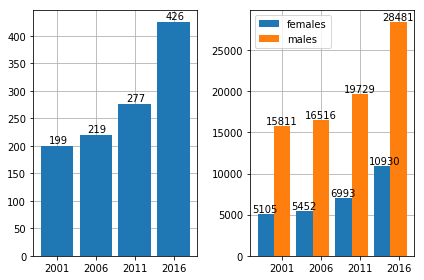

In [4]:
#### TODO: Add tiles for plot
# Plot a Barchart presenting the number of municipalities for which observations are available (1) and for the
# number of candidates per gender (2).

plot_observations_municipalities_candidates(df_main_dataset)

When analysing effects of a female mayor on the rank improvement of a female candidate it seems quite intuitive that candidate's characteristics should be ruled out as the reason for differences in election success between candidates. While this will adressed in a more formal way at a later point of the paper, it might be insightful to compare characteristics (i.e. age, education and occupation) of female candidates only to the characteristics of all candidates. 

In [5]:
# Calculare a descriptive summary table using a function stored in the auxiliary/plots_and_fígures file
summary_stats(df_main_dataset)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


All candidates                                          \
                              Count        Mean        SD      Min      Max   
gewinn_norm                  109017   0.0666775   13.2524 -89.1892  97.2973   
age                           54676     51.5807   13.7804       18      102   
non_university_phd            48729    0.650578  0.476758        0        1   
university                    48729    0.281598  0.449675        0        1   
phd                           48729   0.0678241   0.25149        0        1   
architect                     49399  0.00860341  0.092334        0        1   
businessmanwoman              49399   0.0758922  0.264901        0        1   
engineer                      49399   0.0553048  0.228622        0        1   
lawyer                        49399   0.0313772  0.174319        0        1   
civil_administration          49399   0.0773093   0.26701        0        1   
teacher                       49399    0.051661  0.221369        0        1   
employed                      55416    0.714721  0.451489        0        1   
selfemployed                  55416   0.0584669  0.234624        0        1   
student                       55416   0.0443915  0.205934        0        1   
retired                       55416     0.14393  0.350939        0        1   
housewifehusband              55416   0.0228995  0.149591        0        1   

                     Female candidates                                  \
                                 Count        Mean         SD      Min   
gewinn_norm                      28480   -0.458681    11.9338 -89.1892   
age                              13923      51.035    13.6026       18   
non_university_phd               11734    0.671723   0.469591        0   
university                       11734    0.277399   0.447711        0   
phd                              11734   0.0508778   0.219755        0   
architect                        11832  0.00693036  0.0829653        0   
businessmanwoman                 11832   0.0641481   0.245015        0   
engineer                         11832   0.0138607   0.116922        0   
lawyer                           11832   0.0351589   0.184205        0   
civil_administration             11832   0.0581474    0.23403        0   
teacher                          11832   0.0781778   0.268453        0   
employed                         14043    0.697501   0.459378        0   
selfemployed                     14043   0.0361746   0.186739        0   
student                          14043   0.0516271   0.221288        0   
retired                          14043    0.112868   0.316428        0   
housewifehusband                 14043   0.0880154   0.283326        0   

                               
                          Max  
gewinn_norm           97.2973  
age                        96  
non_university_phd          1  
university                  1  
phd                         1  
architect                   1  
businessmanwoman            1  
engineer                    1  
lawyer                      1  
civil_administration        1  
teacher                     1  
employed                    1  
selfemployed                1  
student                     1  
retired                     1  
housewifehusband            1

This table compares characteristics of council candidates and their success in the election between the whole sample and the exclusively female subsample. There are noticeable differences in the first row "gewinn_norm" which provides data on the normalized rank improvement of a candidate. By showing a lower (even negative) rank improvement on average, females appear to be less successful in council elections than male candidates. 
While most of the candidates' characteristics seem to be quite similar throughout the whole sample, there is some noticeable differences when it comes to the candidates' occupations. While the share of engineers is six times higher in the whole sample then among females, more than four times as many women reported domestic work as their occupation (category "housewifehusband").
While these are the most striking differences, there is smaller but still noticeable differences, e.g. in occupations "selfemployed" and "retired" (both taking higher shares for male candidates) as well as "teacher" and "civil_administration" (both higher for female candidates).
Overall, especially with respect to age and education of the candidates, there seems to be relatively little differences as seen from this descriptive level of inspection.

### 2.2. Discontinuity in Distribution of Observations
In a first step, in order to get a better understanding of the data provided, the relationship of the margin of victory of the female mayor (abscissa) and the rank improvements of female candidates in the subsequent council election (ordinate) is illustrated (see firgure 1). For this exercise, only data on council elections that subceeded mixed gender mayor elections will be used (mayor elections in which two top candidates were of opposite gender). In addition, only rank improvements of female council candidates are of interest for this analysis and are, therefore, included in the illustration below. 

Note that for easier interpretability *rank improvements* in the council elections are provided in a normalized form, facilitating comparability of changes in ranks of candidates between councils of different sizes. This conversion follows the equation: 

$ rank \, improvement = (\frac{initial \, rank - final \, rank}{council \, size}) \times 100. $



In [6]:
# Create a dataset that only contains observations on (a) on rank improvements of female council candidates and 
# (b) mixed gender mayor elections.
rdd_data = df_main_dataset.loc[(df_main_dataset.female == 1) & (df_main_dataset.rdd_sample == 1)]

Figure 1 displayes all available combinations of the rank improvement of a female council candidate and the margin of victory od a female mayor a preceeding mixed gender election. Looking at the distributions of observed combinations, a pattern of *horizontally as well as vertically aligned datapoints* is revealed. First, since the authors work with a dataset that contains the rank improvements of each female council candidate for a given result for the preceeding mayoral election, discrete changes in the horizontal dimension are to be expected. 

Second, the discrete distributionof values in the vertical dimension (along the ordinate) can be explained when a closer look is taken at the distribution of council sizes: As previously described, rank improvements are normalized using the respective size of the council. While the authors do not provide data on the council sizes, this value can easily be deduced from the given values for absolute and relative gains in list ranks for the candidates. As presented in figure 2, sizes of the 214 observed councils are distributed over relatively few values and are clustered at certain values. In addition, 95 % if all councils have not more than 45 seats. It, thus, seems plausible to observe a discrete distribution of normalized rank improvements, given the discussed distibution of council sizes which will cause the denominator for the value on the ordinate to be the same for a large number of observations.


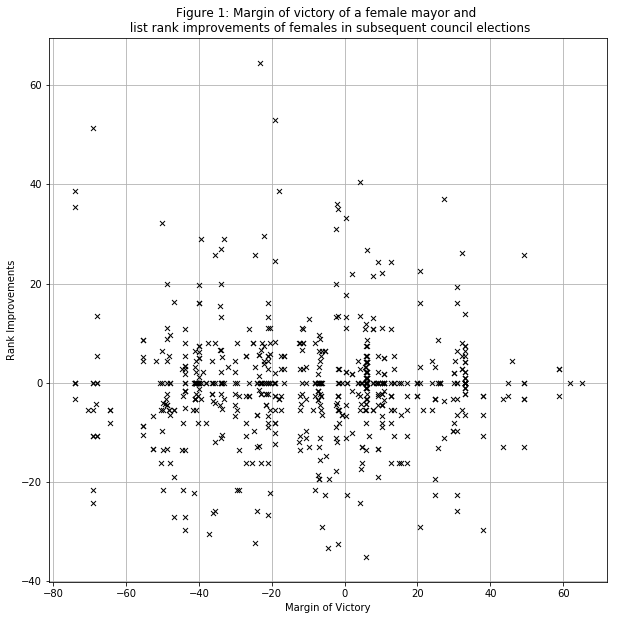

In [7]:
# Create a scatter plot that shows all combinations of the margin of victory of a female 
# in a mixed gender mayor lection and the rank improvements of female candidates in subsequent council elections.
# Function is stored in auxiliary/plots_and_figures
    
plot_observations(df=rdd_data, s=0.1)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

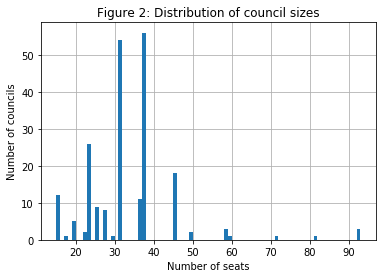

The number of council elections that we have observations for is 214. 
The 95 % percentile of council sizes is 45.


In [8]:
## Find the reason for the discrete changes in gewinn_norm. 
# This would make sense, if the council sizes are small and many councils have same sizes. 

# Deduce the councile size using previously introduced conversion to normalizesd rank improvements. 
council_sizes = rdd_data[['gkz_jahr', 'gewinn_norm', 'gewinn', 'listenplatz_norm']]
council_sizes.loc[:,'council_size'] = council_sizes.loc[:,'gewinn'] / council_sizes.loc[:,'gewinn_norm'] *100

# drop rows where gewinn = 0 since we cannot deduct on council sizes in these cases. 
council_sizes.drop(labels=council_sizes.loc[council_sizes.loc[:, 'gewinn']==0,:].index, axis=0, inplace=True)

# Calculate the 95% percentile of council sizes as well as the number of councils that were voted for. 
N_councils = len(council_sizes.drop_duplicates(subset=['gkz_jahr'])['council_size'])
percentile = int(np.percentile(a=council_sizes.drop_duplicates(subset=['gkz_jahr'])['council_size'], q=95, interpolation='lower'))


# plot a histogram for the council sizes
bins = int((council_sizes['council_size']).max() - (council_sizes['council_size']).min())

hist_council_sizes(df=council_sizes, bins=bins)
print('The number of council elections that we have observations for is {}. \nThe 95 % percentile of council sizes is {}.'.format(N_councils, percentile))

### 2.3. Discontinuity at the Critical Value of the Margin of Victory
Considering figure 1, it is not very obvious if there is a discontinuity around the critical value of margin of victory (i.e. a margin of 0). A jump in values on the ordinate, however, might not be visible in this graphical representation. As discussed previously, observations are not distributed continously but instead show strong discontinuities. This might result in a lot of observations being stacked on top of each other, hence not being represented in above plot.
Another plot, adressing this problem, will be presented in the following section.

## 3. Replication and Critical Review
### 3.1 Graphical Evidence: RDD Plot
A clear discontinuity around the cutoff value of the margin of victory of 0, however, is hard - if at all - to spot in figure 1 presented above. This might be due to the very noisy representation caused by plotting every single observation. Hence, a more promising approach is presented by the authors in *Figure 2. Rank Improvement of Female Candidates* of the article: A RDD-plot for binned normalized rank improvements. A replication of this RDD-plot is displayed in figure 3 below.

In this plot, first, the running variable (female mayor candidate margin of victory) is limited o values from -30 to +30 %. This allows to focus on the part of the data which is most relevant for this analysis. Second, the authors decide to bin the observations into clusters of 3 percentage points width of the running variable. Third, local polynomial regression of the underlying observations is added (red line) estimating the relation of both variables.



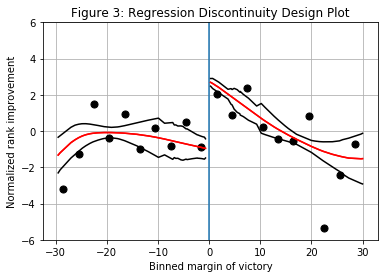

In [9]:
# Keep only observations that fir above described criteria
rdd_plot_data = rdd_data.loc[(rdd_data.margin_1 >= -30) & (rdd_data.margin_1 <= 30)]

# Create the RDD plot using the function stored in the auxiliary file. 
rslt = rdd_plot(data=rdd_plot_data, x_variable="margin_1", y_variable="gewinn_norm", nbins=20, ylimits=(-6,6), width=20.1, deg=1)

### 3.2 Validity of the RD Design
#### 3.2.1 Pretreatment Municipality Characteristics
Check whether the RD design achieves a local randomization.

**TODO: Question: Why is it called "Pretreatment"?**

* Are municipalities in which a female barely won the mayoral election truly non-different from municipalities in which a male candidate barely won?

* Are the characteristics of treated anc control municipalities balanced?

&rarr; Do municipalities' characteristics have explanatory power on the rank improvement? Particularly, in those municipalities close around the cutoff?

&rarr; Run a linear regression with rank improvements as the endogenous variable and include all known characteristics on municipalities as regressors

In [20]:
# Define bandwidth of data around the cutoff value 
bw=100

# define working df that does not contain any missing values and only observations within given bw
df_predicted_rank_improvements = rdd_data.loc[abs(rdd_data["margin_1"])<bw].dropna(subset=["margin_1", 
                                                          "gewinn_norm", 
                                                          "log_bevoelkerung", 
                                                          "log_flaeche", 
                                                          "log_debt_pc", 
                                                          "log_tottaxrev_pc", 
                                                          "log_gemeinde_beschaef_pc", 
                                                          "log_female_sh_gem_besch", 
                                                          "log_tot_beschaeft_pc", 
                                                          "log_female_share_totbesch", 
                                                          "log_prod_share_tot", 
                                                          "log_female_share_prod"
                                                         ]
                                                )

# Run regression of rank improvements on municipalities' characteristics
muni_characteristics = sm.OLS(endog=df_predicted_rank_improvements["gewinn_norm"], 
       exog=df_predicted_rank_improvements[["log_bevoelkerung", 
                      "log_flaeche", 
                      "log_debt_pc", 
                      "log_tottaxrev_pc", 
                      "log_gemeinde_beschaef_pc", 
                      "log_female_sh_gem_besch", 
                      "log_tot_beschaeft_pc", 
                      "log_female_share_totbesch", 
                      "log_prod_share_tot", 
                      "log_female_share_prod"
                     ]]       
      ).fit()

# Add the predicted rank improvement to the dataframe as it is needed in subceeding steps
df_predicted_rank_improvements["pred_rank_improvement"] = muni_characteristics.predict()

# Show regression summary
muni_characteristics.summary()


### TODO: Here might be room for improvement: Use a lasso regression to get rid of the noise introduced by adding a llot of regressors
### which do not seem to be relevant. Maybe this will lead to a better fit. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            gewinn_norm   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     7.314
Date:                Mon, 22 Jul 2019   Prob (F-statistic):           1.29e-11
Time:                        15:35:44   Log-Likelihood:                -24658.
No. Observations:                6403   AIC:                         4.934e+04
Df Residuals:                    6393   BIC:                         4.940e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
log_bevoelkerung              0.9091      0.182      5.006      0.000       0.553       1.265
log_flaeche                  -0.4270      0.275     -1.550      0.121      -0.967       0.113
log_debt_pc                  -0.0114      0.174     -0.066      0.948      -0.353       0.330
log_tottaxrev_pc             -0.0064      0.533     -0.012      0.990      -1.050       1.038
log_gemeinde_beschaef_pc      1.5149      0.323      4.684      0.000       0.881       2.149
log_female_sh_gem_besch      -0.9254      0.571     -1.621      0.105      -2.045       0.194
log_tot_beschaeft_pc         -0.7830      0.420     -1.864      0.062      -1.606       0.040
log_female_share_totbesch     0.6262      1.155      0.542      0.588      -1.638       2.890
log_prod_share_tot            0.2492      0.408      0.611      0.541      -0.550       1.048
log_female_share_prod         0.6815      0.610      1.117      0.264      -0.514       1.877
==============================================================================
Omnibus:                     1681.687   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12773.809
Skew:                           1.048   Prob(JB):                         0.00
Kurtosis:                       9.594   Cond. No.                         107.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only two characteristics of the municipalities reveal to be significantly correlated with the rank improvement of a female candidate: Population size of the munisipality and per capita government employees. 
Even though most of the estimated coefficients result to be individually insignificant, the F-test for all estimators being zero at the same time is rejected. 

While the population size appears to be significantly correlated with rank improvement, the effect is quite small and does not seem economicly significant: An increase of 1 % in population is associated with an increase in rank improvement of a female council candidate of approximatly 0.62/100 normalized ranks. For the median size of a council this corresponds to 0.192 ranks.
Similarly, an increase in government employees is associated with an rank improvement of a female council candidate of approximalty 0.496 ranks.

In a second step, the authors use the prediction for rank improvements from above model and test whether a deiscontinuity around the cutoff value of a margin of victory for a female mayor can be determined. While for the prediction of rank improvements, all observations are included, the second stage regression uses a bandwidth selection method.

In [21]:
# Use predicted values from above regression as endogenous variable in a regresion of female mayor on 
# rank improvements (main model).

# Add predicted values to the dataframe used for this analysis 
#df_predicted_rank_improvements["pred_rank_improvement"] = muni_characteristics.predict()

# Since characteristics are the same within each municipalities, only one value for rank improvement per municipality 
# can be predicted. Hence, drop duplicates.
df_predicted_rank_improvements.drop_duplicates(subset=["pred_rank_improvement", "female_mayor", "margin_1", "inter_1"], 
                                              inplace=True)

# Set the bandwidth (taken from the paper)
bw = 18.81

# Get regression weights
df_predicted_rank_improvements["weight"] = calculate_weights(df=df_predicted_rank_improvements, bandwidth=bw)

# Run regression for approach (1): normalized rank improvement of female candidates on gender of mayor
sm.WLS(endog=df_predicted_rank_improvements.loc[
    abs(df_predicted_rank_improvements["margin_1"])<bw]["pred_rank_improvement"
        ], 
       exog=sm.add_constant(df_predicted_rank_improvements.loc[abs(df_predicted_rank_improvements["margin_1"])<bw][[
           "female_mayor", "margin_1", "inter_1"
       ]]), 
       weights=df_predicted_rank_improvements.loc[abs(df_predicted_rank_improvements["margin_1"])<bw]["weight"],
      ).fit().summary()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              WLS Regression Results                             
=================================================================================
Dep. Variable:     pred_rank_improvement   R-squared:                       0.037
Model:                               WLS   Adj. R-squared:                 -0.006
Method:                    Least Squares   F-statistic:                    0.8670
Date:                   Mon, 22 Jul 2019   Prob (F-statistic):              0.463
Time:                           15:35:51   Log-Likelihood:                -111.93
No. Observations:                     71   AIC:                             231.9
Df Residuals:                         67   BIC:                             240.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4425      0.325     -1.363      0.177      -1.090       0.205
female_mayor     0.4004      0.513      0.781      0.438      -0.623       1.423
margin_1         0.0186      0.045      0.410      0.683      -0.072       0.109
inter_1         -0.0351      0.070     -0.503      0.616      -0.174       0.104
==============================================================================
Omnibus:                        5.589   Durbin-Watson:                   1.114
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                4.976
Skew:                           0.476   Prob(JB):                       0.0831
Kurtosis:                       3.881   Cond. No.                         34.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Female mayor does not show to be statistically significant correlated with the predicted rank improvements of female council candidates. A discontinuity in rank improvements cannot be explained by municipalities's characteristics. 
From above regression result it can be seen, that the explanatory power of the municipalities' characteristics on rank improvements of female council candidates appears to be very limited.

#### 3.2.2 Discontinuity in Density


#### 3.2.3. Confoundness with Mayor Ideology

### 3.3 Main Results
#### 3.3.1 Regression Results

Two different approaches are presented: 
(1) relates gender of incumbent mayor to  a measure of performance (endog. variable is normalized rank improvement) of female candidates
(2) relates gender of incumbent mayor to the likelihood that an elected member of the council in the same municipality is female (endog. variabel is a dummy that is 1 for council members that are female).

Both regressions are performed using different bandwidths and polynomials. For this replication, I will focus on the main results which are basis for the discussion in the article.

* a) bandwidths:
    - **optimal CCT bandwidth (20.1)**
    - CCT / 2 (10.05)
    - CCT * 2 (40.2)
    - IK (35.59)
* b) Polynomials:
    - **linear**
    - quadratic

Only CCT is used for the quadratic specification resulting in five specifications in total. The second approach results in insignificant results while pointestimates seem to be in line with the results of the first approach. 
Since the subsequent discussion in mainly based on the first approach, this will be replicated in the following.

**Approach 1: Rank Improvements of Female Candidates:**

In [ ]:
# Set the bandwidth (taken from the paper)
bw = 20.1

# Get regression weights
rdd_data["weight"] = calculate_weights(df=rdd_data, bandwidth=bw)

# Run regression for approach (1): normalized rank improvement of female candidates on gender of mayor
sm.WLS(endog=rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gewinn_norm"], 
       exog=sm.add_constant(rdd_data.loc[abs(rdd_data["margin_1"])<bw][["female_mayor", "margin_1", "inter_1"]]), 
       weights=rdd_data.loc[abs(rdd_data["margin_1"])<bw]["weight"],
      ).fit(cov_type="cluster", 
             cov_kwds={"groups":rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gkz"]}
            ).summary()

In comparison with the results presented by the authors (see figure 1 below), it can be seen that the point estimate for the effect of a female major at the cutoff value is different. It takes a value of 2.677 in this replication and a value of 3.712 in the results presented in the paper. A difference in results can be seen for all bandwidths used in linear models presented in the article (figure 1, columns 1 - 4).

Furthermore, these main results (table 2 of the article) cannot be replicated using the original stata code provided by authors. The authors appear to use a depricated or manually modified version of the stata package rdrobust which is used in the bandwidth selection process. 

To be more precise, within the *bandwidth_and_weights.ado* file, authors first run the rdrobust function and after that define the optimal bandwidth variable (*bw_opt*) in the following way:
> Global bw_opt : display \%4.2f \`e(h_bw)'  

Thus, authors use a result variable *e_bw* which is provided by the rdrobust function. When running the stata code, above line of code will result in an error. The cause of this error is easily identified: By the documentation of the rdrobust package, this result variable *e_bw* does not exist. In fact, the rdrobust package does not report one single optimal bandwidth but instead reports optimal bandwidths for both, the observations on the right of the cutoff and the observations left from the cutoff, seperatly (result variables *N_r*, *N_l*).
While other parts of the provided stata code indicate that the authors worked with an earlier version of the rdrobust package, too, earlier versions of the rdrobust package are not available on the official website (https://sites.google.com/site/rdpackages/rdrobust/stata).

**Figure 1: Main Results as presented by the authors**
![Figure_1](img/main_results_1.png)



In [ ]:
# Descriptives of the regression result
N = rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gewinn_norm"].count()
elec = rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gkz_jahr"].nunique()
muni = rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gkz"].nunique()
y_mean = rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gewinn_norm"].mean()
y_sd = rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gewinn_norm"].std()
main_result_descriptive = pd.DataFrame(data=[N, elec, muni, y_mean, y_sd], 
                                       index=["Observations", 
                                              "Elections", 
                                              "Municipalities", 
                                              "Dep. Variable Mean", 
                                              "Dep. Variable SD"
                                             ], 
                                       columns = ["value"],
                                      )
main_result_descriptive

As a check for mistakes in the replication process, the descriptive statistics which the authors provide with the main result (see figure 1 above), are replicated as well. All descriptive values calculated for the data used in the replication process match with their counterparts presented by the authors (figure 1). Thus, there is no doubts that the underlying data for the regression analysis are indentical.

Concluding, the deviation in point estimates might be caused by a misinterpretation of the stata code used by the authors. Unfortunatly, neither the code nor a documentation of earlier versions of the rdrobust package are available. Thus, I cannot be certain that the estimation method is replicated flawlessly. 

Finally, although the point estimate of this replication is smaller than the one presented by the authors, it still shows to be significant on the 1 % level.

**Approach 2: Share of Women among Candidates Elected to the Council:**
For the second approach, the gender of an elected council member is used as the endogenous variable while the right side of the regression equation remains the same. Althogh the endogenous variable is a binary variable in this regression equation, the authors apply the same weighted linear regression method which is used in the first approach presented above. 

In [ ]:
# Select data on (a) mixed gender mayor elections and (b) council candidates who were elected
candidates_elected = df_main_dataset.loc[(df_main_dataset.rdd_sample == 1) & (df_main_dataset.elected == 1)]

# set same bandwidth as authors do
bw = 23.90

# Add weighing vector as calculated by the authors
candidates_elected["weight"] = calculate_weights(df=candidates_elected, bandwidth=bw)

# Run regression for approach (2): Gender of an elected council candidate
sm.WLS(endog=candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["female"], 
       exog=sm.add_constant(candidates_elected.loc[abs(candidates_elected["margin_1"])<bw][["female_mayor", "margin_1", "inter_1"]]), 
       weights=candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["weight"],
      ).fit(cov_type="cluster", 
             cov_kwds={"groups":candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["gkz"]}
            ).summary()

In [ ]:
# Calculate descriptives
N = candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["female"].count()
elec = candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["gkz_jahr"].nunique()
muni = candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["gkz"].nunique()
y_mean = candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["female"].mean()
y_sd = candidates_elected.loc[abs(candidates_elected["margin_1"])<bw]["female"].std()
main_result_descriptive = pd.DataFrame(data=[N, elec, muni, y_mean, y_sd], 
                                       index=["Observations", 
                                              "Elections", 
                                              "Municipalities", 
                                              "Dep. Variable Mean", 
                                              "Dep. Variable SD"
                                             ], 
                                       columns = ["value"],
                                      )
main_result_descriptive

#### 3.3.2 Robustness
##### 3.3.2.1 Placebo Test
##### 3.3.2.2 Scaling of the Outcome Variable

In [ ]:
######################################
### Experimenting with partialling out.
### In theory, point estimates must not be different.
### Indeed, they are the same.

# Run regression for approach (1): normalized rank improvement of female candidates on gender of mayor
model_fit = sm.WLS(endog=rdd_data.loc[abs(rdd_data["margin_1"])<bw]["female_mayor"], 
       exog=rdd_data.loc[abs(rdd_data["margin_1"])<bw][["margin_1", "inter_1"]], 
       weights=rdd_data.loc[abs(rdd_data["margin_1"])<bw]["weight"],
      ).fit(cov_type="cluster", 
             cov_kwds={"groups":rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gkz"]}
            )

# calculate residuals
resid = rdd_data.loc[abs(rdd_data["margin_1"])<bw]["female_mayor"] - model_fit.predict()

# use residuals in secondary regression
sm.WLS(endog=rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gewinn_norm"], 
       exog=resid, 
       weights=rdd_data.loc[abs(rdd_data["margin_1"])<bw]["weight"],
      ).fit(cov_type="cluster", 
             cov_kwds={"groups":rdd_data.loc[abs(rdd_data["margin_1"])<bw]["gkz"]}
            ).summary()